# **BSP Project: ECG signal decomposition using Fourier analysis**

*   **Author:** Matteo Onger
*   **Date:** February 2025

**Documentation**:
*   Paper: [ECG signal decomposition using Fourier analysis](https://doi.org/10.1186/s13634-024-01171-x)
*   Dataset: [Lobachevsky University Electrocardiography Database](https://www.physionet.org/content/ludb/1.0.1/)
*   Python packages: [WFDB](https://pypi.org/project/wfdb/)

**Notes**:
*   For faster execution, please use a gpu-equipped runtime.

In [1]:
# install library
!pip install wfdb

# download repository
!git clone -b main https://github.com/MatteoOnger/BSP_Project.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
Cloning into 'BSP_Project'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 29 (delta 4), reused 8 (delta 1), pack-reused 0 (from 0)
Receivi

In [2]:
# ---- LIBRARIES ----
import importlib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

from typing import Literal

from BSP_Project.rbfuncs import GaussianRBF, RadialBasisFunc
from BSP_Project.signals import ECG


# set logger
logging.basicConfig(format="%(asctime)s | %(levelname)s | %(name)s:%(funcName)s - %(message)s", level=logging.INFO, force=True)
logger = logging.getLogger(__name__)


# current runtime type, if gpu available use cupy else numpy
if os.environ["COLAB_GPU"] != "":
    GPU = True
    logger.info("GPU connected")
    logger.info("Load Cupy")
    ncp = importlib.import_module("cupy")
else:
    GPU = False
    logger.info("No accelerator connected")
    ncp = np

2025-01-28 17:34:17,436 | INFO | __main__:<cell line: 0> - No accelerator connected


In [86]:
# ---- FUNCTIONS ----
def dft_l1(x :ncp.ndarray, K :int, max_iters :int=5, eps :float|None=1e-6, fast_init :bool=True) -> ncp.ndarray:
    """
    Computes the l1 Fourier transform of a real signal ``x`` and returns the Fourier coefficients.
    The parameter ``K`` determines the number of Fourier coefficients to compute, so,
    if it is not equal to the length of ``x``, a truncated l1 Fourier trasform is computed.

    Parameters
    ----------
    x : numpy.ndarray | cupy.ndarray of shape \(N)
        Original signal, i.e. an array of ``N`` real numbers that are the samples collected.
    K : int
        Number of Fourier coefficients to compute.
    max_iters : int, optional
        Maximum number of iterations, by default is ``5``.
    eps : float | None, optional
        Tolerance for the convergence of the algorithm, by default is ``1e-6``.
        If ``None``, the algorithm will run until the maximum number of iterations is reached.
    fast_init : bool, optional
        If ``True``, the algorithm will use a faster initialization of the Fourier coefficients, by default is ``True``.

    Returns
    -------
    : numpy.ndarray | cupy.ndarray of shape \(K)
        The Fourier coefficients computed, i.e. an array of ``K`` complex numbers.

    Raises
    ------
    : ValueError
        If ``K != N`` and ``K > 1 + N//2``.

    Notes
    -----
    - If the input signal ``x`` contains complex numbers, only the real part is taken into account.
    """
    N = len(x)
    if (K != N) and (K > 1 + N//2):
        raise ValueError("<K> must be equal to the length of <x> or smaller/equal than half the length of <x> plus 1")

    logger.info(f"Start -> K={K}, max_iters={max_iters}, eps={eps}")

    # if gpu available, move data to the device
    isnumpy = isinstance(x, np.ndarray)
    if GPU and isnumpy:
        x = ncp.asarray(x)

    # keep only real part
    x = ncp.real(x)

    # total number of coefficients computed
    # including complex conjugates
    M = 2*K - 1 if K != N else K
    if (N % 2 == 0) and (K == 1 + N//2):
        M -= 1

    # fourier basis, matrix of shape (N,M) and its conjugate transpose
    fi = ncp.exp(ncp.array([[1j * (2 * ncp.pi * k / N) * n for k in range(K-M, K, 1)] for n in range(N)])) / ncp.sqrt(N)
    tconj_fi = ncp.transpose(ncp.conj(fi))

    # init fourier coefficients
    coeff = ncp.zeros(fi.shape[1], dtype=ncp.complex128)
    # reconstructed signal
    xk = x + 1 if fast_init else ncp.real(fi @ coeff)
    # previously recon. signal
    prev_xk = None

    for iter in range(max_iters):
        delta = ncp.abs(x - xk)
        delta = ncp.diag(1 / ncp.where(delta == 0, 1e-18, delta))

        # update fourier coefficients and prev. recon. signal and recon. signal
        coeff = ncp.linalg.inv(tconj_fi @ delta @ fi) @ tconj_fi @ delta @ x
        prev_xk = xk
        xk = ncp.real(fi @ coeff)

        # check convergency
        conv = np.mean(np.abs(xk - prev_xk))
        logger.debug(f"Iteration {iter+1} -> convergency={conv}")
        if (eps is not None) and (conv <= eps):
            break

    # compute final convergency and loss wrt original signal
    conv, loss = np.mean(np.abs(xk - prev_xk)), ncp.abs((x - xk) / np.where(x == 0, 1, x))
    logger.info(f"End -> iter={iter+1}, " +
        f"convergency={ncp.round(conv, 4)}, " +
        f"min_abs_loss={ncp.around(ncp.min(loss), 4)}, "  +
        f"avg_abs_loss={ncp.around(ncp.mean(loss), 4)}, " +
        f"max_abs_loss={ncp.around(ncp.max(loss), 4)}"
    )
    return ncp.asnumpy(coeff[-K:]) if GPU and isnumpy else coeff[-K:]


def idft_l1(coeff :ncp.ndarray, N :int, onlyreal :bool=False) -> ncp.ndarray:
    """
    Computes the inverse l1 Fourier transform of a real signal ``x`` given its Fourier coefficients ``coeff``
    and returns the reconstructed signal.

    Parameters
    ----------
    coeff : numpy.ndarray | cupy.ndarray of shape \(K)
        Fourier coefficients, i.e. an array of ``K`` complex numbers.
    N : int
        Length of the signal to reconstruct.
    onlyreal : bool, optional
        If ``True``, only the real part of the reconstructed signal is returned, by default is ``False``.

    Returns
    -------
    : numpy.ndarray | cupy.ndarray of shape \(N)
        The reconstructed signal, i.e. an array of ``N`` real numbers.

    Raises
    ------
    : ValueError
        If ``K != N`` and ``K > 1 + N//2``.
    """
    K = len(coeff)
    if (K != N) and (K > 1 + N//2):
        raise ValueError("the number of coefficients must be equal to <N> or smaller/equal than <N> half plus 1")

    # if gpu available, move data to the device
    isnumpy = isinstance(coeff, np.ndarray)
    if GPU and isnumpy:
        coeff = ncp.asarray(coeff)

    # total number of coefficients computed
    # including complex conjugates
    M = 2*K - 1 if K != N else K
    if (N % 2 == 0) and (K == 1 + N//2):
        M -= 1

    # fourier basis, matrix of shape (N,M)
    fi = ncp.exp(ncp.array([[1j * (2 * ncp.pi * k / N) * n for k in range(K-M, K, 1)] for n in range(N)])) / ncp.sqrt(N)

    # if not given, compute conjugate fourier coefficients
    if N != K:
        if (N % 2 == 0) and (K == 1 + N//2):
            coeff = ncp.concatenate((ncp.conj(coeff[1:-1][::-1]), coeff))
        else:
            coeff = ncp.concatenate((ncp.conj(coeff[1:][::-1]), coeff))

    # reconstructed signal
    xk = ncp.real(fi @ coeff) if onlyreal else fi @ coeff
    return ncp.asnumpy(xk) if GPU and isnumpy else xk


def derivatives(x : ncp.ndarray) -> ncp.ndarray:
    """
    """
    # if gpu available, move data to the device
    isnumpy = isinstance(x, np.ndarray)
    if GPU and isnumpy:
        x = ncp.asarray(x)

    # derivatives between adjacent samples
    ders = (ncp.roll(x, -1) - x)
    ders[-1] = 0
    return ncp.asnumpy(ders) if GPU and isnumpy else ders


def avg_derivatives(x :ncp.ndarray, l :int) -> ncp.ndarray:
    """
    """
    # if gpu available, move data to the device
    isnumpy = isinstance(x, np.ndarray)
    if GPU and isnumpy:
        x = ncp.asarray(x)

    # derivatives between adjacent samples
    ders = (ncp.roll(x, -1) - x)
    ders[-1] = 0

    # convolution to compute average derivatives
    kernel = ncp.array([1] * l)
    conv = ncp.convolve(ders, kernel, mode="full") / l

    # avg of the <l> previous and <l> next derivatives
    avg_ders = ncp.zeros((len(x), 2))
    avg_ders[:, 0] = ncp.roll(conv, l)[l-1:]
    avg_ders[:, 1] = conv[l-1:]
    return ncp.asnumpy(avg_ders) if GPU and isnumpy else avg_ders


def detect_waves(x :ncp.ndarray, fm :int, to :int, l :int, rbf :RadialBasisFunc, mode :Literal['rand', 'threshold'], threshold :float|None=None) -> ncp.ndarray:
    """
    """
    if mode not in ['rand', 'threshold']:
        logger.error("Mode must be 'rand' or 'threshold'")
        raise ValueError("Mode must be 'rand' or 'threshold'")
    if mode == "threshold" and threshold is None:
        logger.error("Threshold must be given if mode is 'threshold'")
        raise ValueError("Threshold must be given if mode is 'threshold'")

    # if gpu available, move data to the device
    isnumpy = isinstance(x, np.ndarray)
    if GPU and isnumpy:
        x = ncp.asarray(x)

    # avg of the <l> previous and <l> next derivatives
    avg_ders = avg_derivatives(x, l)


    # sample indeces corresponding to the start, peak and end point of each wave
    samples = ncp.zeros((len(x), 3), dtype=ncp.int_)
    counter = 0

    # find onset samples
    onset_delta = avg_ders[:, 1] - ncp.abs(avg_ders[:, 0])
    argsort_onset_delta = ncp.argsort(onset_delta)[::-1]

    for sample in argsort_onset_delta:
        if (sample < fm) or (sample >= len(x)-to):
            continue

        if counter == 0:
            samples[counter, 0] = sample
            counter += 1
            continue

        dist = ncp.min(ncp.abs(samples[:counter, 0] - sample))
        prob = rbf.f(dist)

        if mode == "rand":
            if ncp.random.rand(1) < prob:
                samples[counter, 0] = sample
                counter += 1
        elif mode == "threshold":
            if prob > threshold:
                samples[counter, 0] = sample
                counter += 1


    # free memory
    del onset_delta, argsort_onset_delta

    # sort samples
    samples = ncp.sort(samples[:counter, :], axis=0)
    counter = 0

    # find offset samples
    offset_delta = avg_ders[:, 0] + ncp.abs(avg_ders[:, 1])
    argsort_offset_delta = ncp.argsort(offset_delta)

    for sample in argsort_offset_delta:
        if (sample < fm) or (sample >= len(x)-to) or sample <= samples[0, 0]:
            continue

        if counter == 0:
            samples[counter, 2] = sample
            counter += 1
            continue

        dist = ncp.min(ncp.abs(samples[:counter, 2] - sample))
        prob = rbf.f(dist)

        if mode == "rand":
            if ncp.random.rand(1) < prob:
                samples[counter, 2] = sample
                counter += 1
        elif mode == "threshold":
            if prob > threshold:
                samples[counter, 2] = sample
                counter += 1

        if counter == len(samples):
            break

    #free memory
    del offset_delta, argsort_offset_delta

    samples[:, 2] = ncp.sort(samples[:, 2])

    for i in range(len(samples)):
        samples[i, 1] = np.argmax(x[samples[i,0]:samples[i,2]]) + samples[i,0]
    return ncp.asnumpy(samples) if GPU and isnumpy else samples

## Two examples:

2025-01-27 21:58:28,543 | INFO | __main__:dft_l1 - Start -> K=1000, max_iters=5, eps=1e-06
2025-01-27 21:58:30,941 | INFO | __main__:dft_l1 - End -> iter=2, convergency=0.0, min_abs_loss=0.0, avg_abs_loss=0.0, max_abs_loss=0.0
2025-01-27 21:58:30,943 | INFO | __main__:dft_l1 - Start -> K=501, max_iters=5, eps=1e-06
2025-01-27 21:58:33,252 | INFO | __main__:dft_l1 - End -> iter=2, convergency=0.0, min_abs_loss=0.0, avg_abs_loss=0.0, max_abs_loss=0.0
2025-01-27 21:58:33,254 | INFO | __main__:dft_l1 - Start -> K=10, max_iters=5, eps=1e-06
2025-01-27 21:58:33,333 | INFO | __main__:dft_l1 - End -> iter=5, convergency=0.0015, min_abs_loss=0.0035, avg_abs_loss=3.0329, max_abs_loss=504.6002


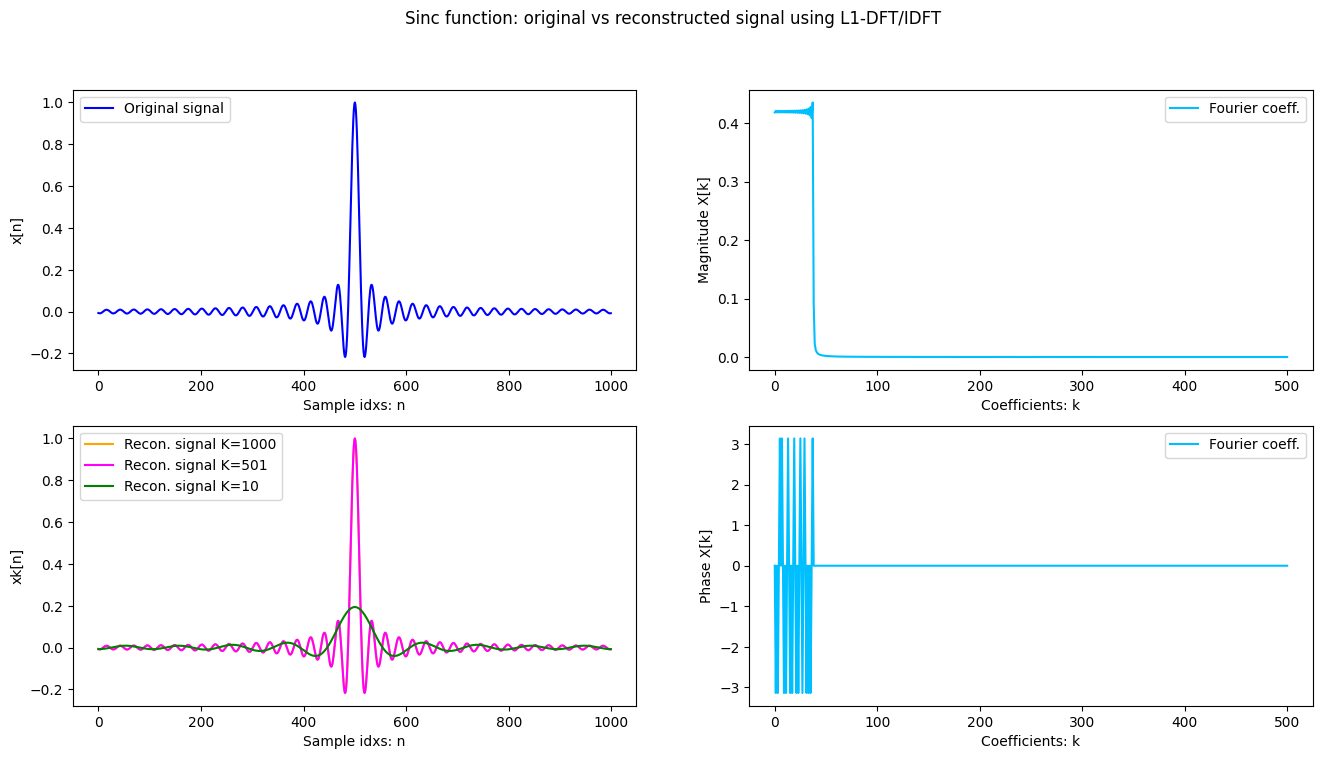

In [ ]:
# frequency
f = 12
# number of samples
N = 1000

# original signal
n = np.arange(N)
x = np.sinc(2 * np.pi * f * np.linspace(-0.5, 0.5, N, endpoint=False))

# compute dft and reconstruct the signal
c1 = dft_l1(x, K=1000)
c2 = dft_l1(x, K=501)
c3 = dft_l1(x, K=10)

xk1 = idft_l1(c1, N=N, onlyreal=True)
xk2 = idft_l1(c2, N=N, onlyreal=True)
xk3 = idft_l1(c3, N=N, onlyreal=True)

# plot the results
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle("Sinc function: original vs reconstructed signal using L1-DFT/IDFT")

axs[0, 0].plot(n, x, c="blue", label="Original signal")
axs[0, 0].set(xlabel="Sample idxs: n", ylabel="x[n]")
axs[0, 0].legend(loc="upper left")

axs[1, 0].plot(n, xk1, c="orange", label="Recon. signal K=1000")
axs[1, 0].plot(n, xk2, c="magenta", label="Recon. signal K=501")
axs[1, 0].plot(n, xk3, c="green", label="Recon. signal K=10")
axs[1, 0].set(xlabel="Sample idxs: n", ylabel="xk[n]")
axs[1, 0].legend(loc="upper left")

axs[0, 1].plot(n[:501], np.abs(c1[:501]), c="deepskyblue", label="Fourier coeff.")
axs[0, 1].set(xlabel="Coefficients: k", ylabel="Magnitude X[k]")
axs[0, 1].legend(loc="upper right")

axs[1, 1].plot(n[:501], np.angle(c1[:501]), c="deepskyblue", label="Fourier coeff.")
axs[1, 1].set(xlabel="Coefficients: k", ylabel="Phase X[k]")
axs[1, 1].legend(loc="upper right")

plt.show()

2025-01-27 21:58:34,852 | INFO | __main__:dft_l1 - Start -> K=10, max_iters=10, eps=1e-06
2025-01-27 21:58:35,122 | INFO | __main__:dft_l1 - End -> iter=10, convergency=0.001, min_abs_loss=0.0001, avg_abs_loss=0.0455, max_abs_loss=0.4927


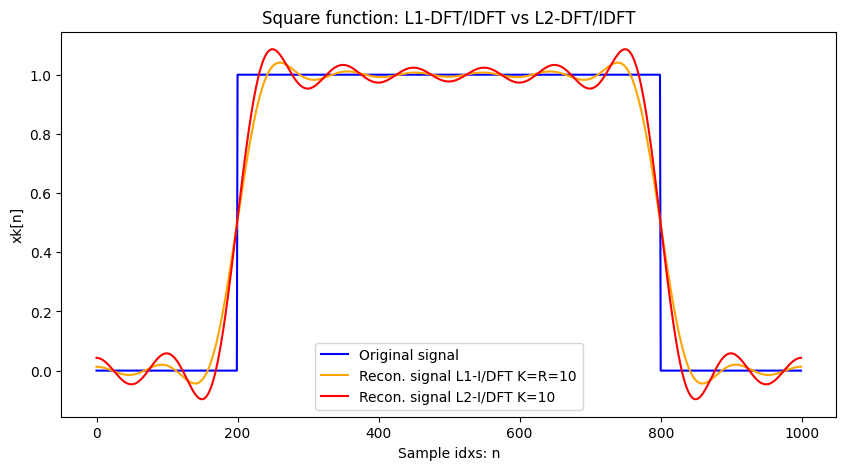

In [ ]:
# number of samples
N = 1000

# original signal
n = np.arange(N)
x = np.array([0] * (N//5) + [1] * (3*N//5) + [0] * (N//5))

# compute dft and reconstruct the signal
c1 = dft_l1(x, K=10, max_iters=10)
c2 = np.fft.fft(x) * np.array([1] * (10) + [0] * (N-19) + [1] * (9))

xk1 = idft_l1(c1, N=N, onlyreal=True)
xk2 = np.real(np.fft.ifft(c2))

# plot the results
plt.figure(figsize=(10, 5))
plt.title("Square function: L1-DFT/IDFT vs L2-DFT/IDFT")
plt.plot(n, x, c="blue", label="Original signal")
plt.plot(n, xk1, c="orange", label="Recon. signal L1-I/DFT K=R=10")
plt.plot(n, xk2, c="red", label="Recon. signal L2-I/DFT K=10")
plt.xlabel("Sample idxs: n")
plt.ylabel("xk[n]")
plt.legend(loc="lower center")
plt.show()

## ECG decomposition

In [ ]:
#import locale
#def getpreferredencoding(do_setlocale = True):
#    return "UTF-8"
#locale.getpreferredencoding = getpreferredencoding

In [ ]:
# download dataset
!wget -r -N -c -np https://physionet.org/files/ludb/1.0.1/
DATAPATH = "/content/physionet.org/files/ludb/1.0.1/data/"

In [ ]:
ecg = ECG(DATAPATH, "178")

n = np.arange(ecg.size)
x = ecg.get_p_signal(ECG.Lead.V3)

c = dft_l1(x, K=64, max_iters=100, eps=1e-5)
xk = idft_l1(c, N=ecg.size, onlyreal=True)

ders = derivatives(xk)
idxs = ecg.t_waves(ECG.Lead.V3)

rbf = GaussianRBF(sigma=1/375)
abc = detect_waves(xk, fm=150, to=150, l=35, rbf=rbf, mode="threshold", threshold=0.4)

abc

In [ ]:
plt.figure(figsize=(30, 15))

plt.axhline(y=0, c="red", linestyle="dashed", alpha=0.3)

plt.plot(n, x, c="black")
plt.plot(n, xk, c="blue")

plt.plot(n, 10*ders, c="yellow")

for e in idxs:
    plt.axvline(x=e[0], c="purple")
    plt.axvline(x=e[1], c="magenta")
    plt.axvline(x=e[2], c="purple")

for e in abc:
    plt.axvline(x=e[0], c="darkorange")
    plt.axvline(x=e[1], c="green")
    plt.axvline(x=e[2], c="darkorange")

plt.xlim(1000, 2000)
plt.show()